In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
%matplotlib inline

from helper.rl_framework import *
from helper.rl_functions import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks_v2 import *
from helper.orderbook_trader import *


# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

/Users/axelperschmann/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [2]:
# filename = '../data/snapshots/orderbooks_USDT_BTC_range1.15_samplesNone_snapshot2017-01-11T17:19.dict'
filename = '3000orderbooks'
currency_pair = 'USDT_BTC'
offset = 0
orderbooks = load_orderbook_snapshot(infile=filename, last_line=240)  #, first_line=offset+0, last_line=offset+10)
print("Successfully loaded {} orderbooks from '{}'".format(len(orderbooks), filename))
print(orderbooks[0])

100%|██████████| 240/240 [00:09<00:00, 25.63it/s]

Loaded 240 orderbooks from file '3000orderbooks'.
Successfully loaded 240 orderbooks from '3000orderbooks'
OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'


### Settings

In [3]:
V = 100  # trading volume
T = 8  # Time horizon: 10 periods -> P*T = 20 minutes
P = 2  # period length
print("V={}, T={}, P={}".format(V, T, P))

V=100, T=8, P=2


#### Split orderbook array into non-overlapping episodes

Episodes: 15, episode length: 16


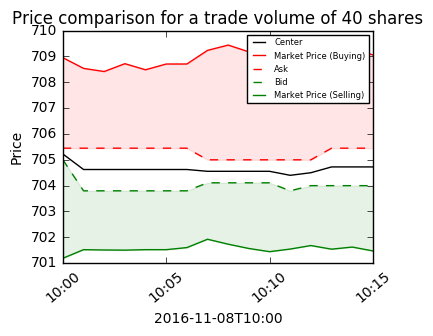

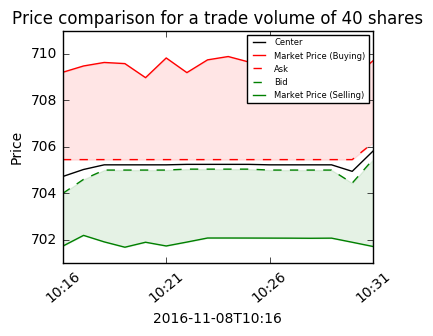

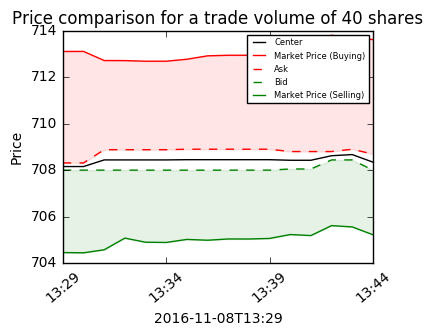

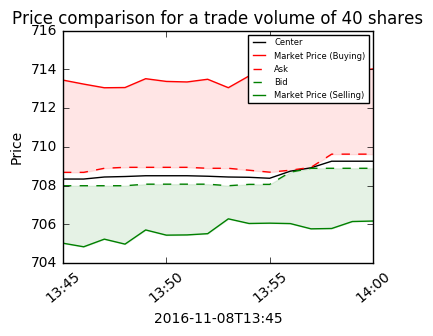

In [22]:
def create_episodes(orderbooks, episode_length):
    episode_windows = []
    for e in range(0, len(orderbooks) / episode_length):
        window = [ob.copy() for ob in orderbooks[e*episode_length:(e+1)*episode_length]]

        # plot_episode(window, volume=V, outfile='graphs/episode_window{}'.format(e))
        episode_windows.append(window)
    return episode_windows

episode_windows = create_episodes(orderbooks, episode_length=T*P)

print("Episodes: {}, episode length: {}".format(len(episode_windows), len(episode_windows[0])))
plot_episode(episode_windows[0], volume=40)
plot_episode(episode_windows[1], volume=40)
plot_episode(episode_windows[-2], volume=40)
plot_episode(episode_windows[-1], volume=40)

In [5]:
STATE_DIM = 2
NUM_ACTIONS = 51
actions = np.linspace(-1, 1, num=NUM_ACTIONS)

In [ ]:
def plot_Q_v2(model, V, T, actions, STATE_DIM=2, outfile=None, outformat=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    df = np.zeros((V, T))   
    for t in range(T):
        for v in range(V):
            state = np.array([t, v])
            qval = model.predict(state.reshape(1, STATE_DIM))
            df[v, t] = actions[np.argmin(qval)]
        
    display(df)
    ax.bar3d(range(V)*T, range(T)*V, np.zeros(T*V), 0.5, 0.5, df.flatten(order='F'), color='#00ceaa')
    ax.set_zlim(-1, 1),

    ax.set_xlabel("time remaining")
    ax.set_ylabel("shares remaining")
    ax.set_zlabel("aggression level")
    plt.title("Q function")
    if outfile:
        if outfile[-3:] != outformat:
            outfile = "{}.{}".format(outfile, outformat)
        plt.savefig(outfile, format=outformat)
        print("Successfully saved '{}'".format(outfile))
    else:
        plt.show()
    plt.close()
model = base_model()

V=10
T=4
print(V, T)


plot_Q_v2(model, V, T, actions, STATE_DIM)

In [ ]:
model = base_model()
plot_Q(model, V, T, actions, STATE_DIM)



In [ ]:
model = base_model()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for t in range(T):
    xs = np.arange(V)
    
    ys = np.zeros(V)
    for v in range(V):
        state = np.array([t, v])
        qval = model.predict(state.reshape(1, STATE_DIM))
        ys[v] = actions[np.argmin(qval)]
    

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    ax.bar(xs, ys, zs=t, zdir='y', alpha=0.5)

ax.set_xlabel("time remaining")
ax.set_ylabel("shares remaining")
ax.set_zlabel("aggression level")
plt.title("Q function")
if outfile:
    if outfile[-3:] != outf_ormat:
        outfile = "{}.{}".format(outfile, outformat)
    plt.savefig(outfile, format=outformat)
    print("Successfully saved '{}'".format(outfile))
else:
    plt.show()
plt.close()

In [ ]:
def plot_Q(model, actions, T, V, outfile=None, outformat='pdf'):
    assert isinstance(model, Sequential)
    assert isinstance(actions, np.ndarray) and len(actions) > 0 and isinstance(actions[0], (float, int)), type(actions)
    assert isinstance(T, int) and T > 0
    assert isinstance(V, (float, int)) and V != 0
    assert isinstance(outfile, (str, unicode)) or outfile is None
    assert isinstance(outformat, (str, unicode))
    
    print("T: {}, V: {}".format(T, V))
    print("actions: {}".format(actions))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for c, z in zip(['r', 'g', 'b', 'y'], [3, 2, 1, 0]):
        print(c, z)
        xs = np.arange(20)
        ys = 3.3
        
        print(xs, ys)

        ax.bar(xs, ys, zs=z, zdir='y', alpha=0.8)
    plt.show()
    
    # Make data.
    X = np.arange(0, T, 1)
    Y = np.arange(0, V, 1)
    X, Y = np.meshgrid(X, Y)
    
    Z = np.zeros((V, T))
    for x, time_left in enumerate(range(T)):
        for y, volume in enumerate(range(V)):
            state = np.array([time_left, volume])
            qval = model.predict(state.reshape(1, STATE_DIM))
            Z[y,x] = actions[np.argmin(qval)]

    # Plot the surface.
    # surf = ax.plot_surface(X, Y, Z,
    #                        linewidth=0.1, antialiased=False, alpha=0.3, rstride=5, cstride=1)
    
    xpos = np.arange(0, T*V, 1)
    ypos = np.arange(0, V*T, 1)
    # ypos = [2,3,4,5,1,6,2,1,7,2]
    num_elements = len(xpos)
    zpos = [0,0,0,0,0,0,0,0,0,0]
    
    print(len(xpos), len(ypos), len(zpos))
    dx = np.ones(len(xpos))
    dy = np.ones(len(ypos))
    dz = [3,2,3,4,5,6,7,8,9,10]

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='#00ceaa')
    # plt.show()
    
    
    # plt.gca().invert_yaxis()
    # plt.gca().invert_xaxis()
    ax.set_xlabel("time remaining")
    ax.set_ylabel("shares remaining")
    ax.set_zlabel("aggression level")
    plt.title("Q function")
    if outfile:
        if outfile[-3:] != outf_ormat:
            outfile = "{}.{}".format(outfile, outformat)
        plt.savefig(outfile, format=outformat)
        print("Successfully saved '{}'".format(outfile))
    else:
        plt.show()
    plt.close()
    
model = base_model()
plot_Q(model, actions, T, V)  #, outfile="Q_function.pdf")

In [6]:
def base_model():
    model = Sequential()
    model.add(Dense(64, input_dim=STATE_DIM, activation='relu', init='glorot_normal'))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(NUM_ACTIONS, activation='linear', init='glorot_normal'))
    model.compile(loss='mse', optimizer='Adam')
    return model
model = base_model()
# visualize_Q(model, actions, V, T)

In [7]:
def train_RL(V, T, P, epochs, gamma=0.95, DECAY_RATE=0.005, epsilon=1., bufferSize=50, batchSize=30, verbose=False, log=None):
    
    model = base_model()
    if log:
        log = open('logs/RL_train_{}.log'.format(datetime.now().isoformat()[2:-10]), 'w')
        log.write("RL training started\n")
        log.write("Actions: {}\n".format(actions))
        log.write("V={}, T={}, P={}\n".format(V, T, P))
        log.write("Compiled model!")
    MAX_EXPLORATION_RATE = 1.
    MIN_EXPLORATION_RATE = 0.05
    
    min_costs = np.inf

    replay = Memory(bufferSize)
    # stores tuples of (S, A, R, S')

    for i_episode in tqdm(range(epochs)):
        # obs = episode_windows[0]  # episode_windows[i]  # Testcase with always the same, identical episode_window

        ots = OrderbookTradingSimulator(orderbooks=episode_windows[1], volume=V, tradingperiods=T, decisionfrequency=P)

        time_left = T
        volume = V
        action_history = []
        state = np.array([time_left, volume])  # volume])

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            # print("     {}".format(qval))

            # ob = obs[step*P]
 
            if random.random() < epsilon:
                # choose random action
                #action = random.randint(0, len(actions)-1)
                # action = round(random.random()*2.-1, 1)
                action = random.choice(actions)
            else:
                # choose best action from Q(s,a) values
                action = actions[np.argmin(qval)]
            action_history.append(action)    
            if verbose:
                print("{}: action {}".format(action, actions[action]))
                
            # if V > 0:
            #     best_price = ob.get_ask()
            # elif V < 0:
            #     best_price = ob.get_bid()
            # else:
            #     assert(1 == 2), "Error!"
            # lim = best_price - actions[action]
            
            # orderbooks = obs[step*P:(step+1)*P]
            lim = 707.55
            info = ots.trade(limit=lim, verbose=False, extrainfo={'ACTION':action})  #agression_factor=action


            time_left -= 1
            volume = ots.volume

            new_state = np.array([time_left, volume])  # volume, 
            cost = ots.history.cost.values[-1]
            if info['forced'].values[0]:
                pass
                # cost *= 3
            acc_cost += cost

            replay.add((state, action, cost, new_state))
            if (replay.size() >= bufferSize):
                # wait for buffer to be filled, before getting started with training
                minibatch = replay.get_random_samples(batchSize)           

                X_train = []
                y_train = []
                for memory in minibatch:
                    state_m, action_m, cost_m, new_state_m = memory

                    qval_old = model.predict(state_m.reshape(1, STATE_DIM))               
                    y = np.zeros((1, NUM_ACTIONS))
                    y[:] = qval_old[:]

                    qval_new_m = model.predict(new_state_m.reshape(1, STATE_DIM), batch_size=1)
                    maxQ = np.max(qval_new_m)

                    update = cost_m + (gamma*maxQ)
                    y[0][action_m] = update  # target output

                    X_train.append(state_m.reshape(STATE_DIM,))
                    y_train.append(y.reshape(NUM_ACTIONS,))
                X_train = np.array(X_train)
                y_train = np.array(y_train)

                # print("Game #: %s" % (i_episode,))
                model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            state = new_state
            if volume == 0:
                # display(ots.history)
                break

        # reduce exploration rate
        if epsilon > MIN_EXPLORATION_RATE:
            epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)
            
        forced_trade = ""
        if info['forced'].values[0]:
            forced_trade = ", forced!"
        info = "{:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, steps: {} (t={}) {}\n"\
                .format(i_episode+1, epochs, epsilon,  acc_cost, step, ots.t, forced_trade)
        if log:
            log.write(info)
        if min_costs > acc_cost:
            min_costs = acc_cost
            if log:
                log.write("   {}\n".format(action_history))
            
            print(info)
            print("   {}".format(action_history))
            display(ots.history)
        # print("     {}".format(action_history))
    log.close()

In [9]:
V=100
T=8
P=2

train_RL(V=V, T=T, P=P, epochs=100, verbose=False, log=True)

  0%|          | 0/100 [00:00<?, ?it/s]

(16, 8, 2)
   1/100: epsilon=1.000, acc_cost: 1.05717, steps: 7 (t=16) , forced!

   [0.040000000000000036, 0.19999999999999996, -0.28000000000000003, -0.56000000000000005, 0.91999999999999993, -0.23999999999999999, 0.88000000000000012, -0.92000000000000004]


,ACTION,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T10:16,0.04,705.45,704.00,704.724751,707.55,1.45,2,100.000000,706.70739,-9949.122560,0.039607,0,False,707.52,705.450000,14.078136
2016-11-08T10:18,0.20,707.84,705.00,706.419049,707.55,2.84,2,85.921864,0.00000,0.000000,0.000000,0,False,0.00,inf,0.000000
2016-11-08T10:20,-0.28,707.33,705.00,706.164359,707.55,2.33,2,85.921864,707.33000,-2136.819039,0.011168,0,False,707.33,707.330000,3.020965
2016-11-08T10:22,-0.56,707.84,705.04,706.439075,707.55,2.80,2,82.900899,0.00000,0.000000,0.000000,0,False,0.00,inf,0.000000
2016-11-08T10:24,0.92,709.25,705.04,707.142911,707.55,4.21,2,82.900899,0.00000,0.000000,0.000000,0,False,0.00,inf,0.000000
2016-11-08T10:26,-0.24,707.83,705.00,706.414055,707.55,2.83,2,82.900899,0.00000,0.000000,0.000000,0,False,0.00,inf,0.000000
2016-11-08T10:28,0.88,709.63,705.00,707.312474,707.55,4.63,2,82.900899,0.00000,0.000000,0.000000,0,False,0.00,inf,0.000000
2016-11-08T10:30,-0.92,707.83,704.44,706.133644,707.55,3.39,2,82.900899,713.27995,-59131.549629,1.006398,0,True,715.00,709.250000,82.900899


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

(16, 8, 2)


  2%|▏         | 2/100 [00:03<02:36,  1.60s/it]

(16, 8, 2)


  3%|▎         | 3/100 [00:04<02:33,  1.59s/it]

(16, 8, 2)


  4%|▍         | 4/100 [00:06<02:34,  1.61s/it]

(16, 8, 2)


  5%|▌         | 5/100 [00:07<02:32,  1.61s/it]

(16, 8, 2)


  6%|▌         | 6/100 [00:09<02:30,  1.60s/it]

(16, 8, 2)


/Users/axelperschmann/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:88: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  7%|▋         | 7/100 [00:11<02:48,  1.81s/it]

(16, 8, 2)


  8%|▊         | 8/100 [00:13<02:46,  1.81s/it]

(16, 8, 2)


  9%|▉         | 9/100 [00:15<02:42,  1.79s/it]

(16, 8, 2)


 10%|█         | 10/100 [00:17<02:41,  1.79s/it]

(16, 8, 2)


 11%|█         | 11/100 [00:18<02:38,  1.78s/it]

(16, 8, 2)


 12%|█▏        | 12/100 [00:20<02:35,  1.77s/it]

(16, 8, 2)


 13%|█▎        | 13/100 [00:22<02:32,  1.76s/it]

(16, 8, 2)


 14%|█▍        | 14/100 [00:24<02:31,  1.76s/it]

(16, 8, 2)


 15%|█▌        | 15/100 [00:25<02:29,  1.76s/it]

(16, 8, 2)


 16%|█▌        | 16/100 [00:27<02:29,  1.78s/it]

(16, 8, 2)


 17%|█▋        | 17/100 [00:29<02:28,  1.79s/it]

(16, 8, 2)


 18%|█▊        | 18/100 [00:31<02:25,  1.77s/it]

(16, 8, 2)


 19%|█▉        | 19/100 [00:33<02:22,  1.76s/it]

(16, 8, 2)


 20%|██        | 20/100 [00:34<02:20,  1.76s/it]

(16, 8, 2)


 21%|██        | 21/100 [00:36<02:18,  1.75s/it]

(16, 8, 2)


 22%|██▏       | 22/100 [00:38<02:15,  1.74s/it]

(16, 8, 2)


 23%|██▎       | 23/100 [00:40<02:13,  1.74s/it]

(16, 8, 2)


 24%|██▍       | 24/100 [00:41<02:12,  1.74s/it]

(16, 8, 2)


 25%|██▌       | 25/100 [00:43<02:10,  1.74s/it]

(16, 8, 2)


 26%|██▌       | 26/100 [00:45<02:08,  1.74s/it]

(16, 8, 2)


 27%|██▋       | 27/100 [00:46<02:06,  1.74s/it]

(16, 8, 2)


 28%|██▊       | 28/100 [00:48<02:04,  1.73s/it]

(16, 8, 2)


 29%|██▉       | 29/100 [00:50<02:03,  1.73s/it]

(16, 8, 2)


 30%|███       | 30/100 [00:52<02:02,  1.75s/it]

(16, 8, 2)


 31%|███       | 31/100 [00:53<02:00,  1.75s/it]

(16, 8, 2)


 32%|███▏      | 32/100 [00:55<01:59,  1.76s/it]

(16, 8, 2)


 33%|███▎      | 33/100 [00:57<01:57,  1.75s/it]

(16, 8, 2)


 34%|███▍      | 34/100 [00:59<01:55,  1.75s/it]

(16, 8, 2)


 35%|███▌      | 35/100 [01:00<01:53,  1.75s/it]

(16, 8, 2)


 36%|███▌      | 36/100 [01:02<01:51,  1.74s/it]

(16, 8, 2)


 37%|███▋      | 37/100 [01:04<01:50,  1.75s/it]

(16, 8, 2)


 38%|███▊      | 38/100 [01:06<01:47,  1.73s/it]

(16, 8, 2)


 39%|███▉      | 39/100 [01:07<01:45,  1.73s/it]

(16, 8, 2)


 40%|████      | 40/100 [01:09<01:43,  1.72s/it]

(16, 8, 2)


 41%|████      | 41/100 [01:11<01:41,  1.72s/it]

(16, 8, 2)


 42%|████▏     | 42/100 [01:13<01:39,  1.72s/it]

(16, 8, 2)


 43%|████▎     | 43/100 [01:14<01:37,  1.72s/it]

(16, 8, 2)


 44%|████▍     | 44/100 [01:16<01:36,  1.72s/it]

(16, 8, 2)


 45%|████▌     | 45/100 [01:18<01:35,  1.73s/it]

(16, 8, 2)


 46%|████▌     | 46/100 [01:19<01:33,  1.73s/it]

(16, 8, 2)


 47%|████▋     | 47/100 [01:21<01:31,  1.74s/it]

(16, 8, 2)


 48%|████▊     | 48/100 [01:23<01:29,  1.73s/it]

(16, 8, 2)


 49%|████▉     | 49/100 [01:25<01:28,  1.74s/it]

(16, 8, 2)


 50%|█████     | 50/100 [01:26<01:26,  1.73s/it]

(16, 8, 2)


 51%|█████     | 51/100 [01:28<01:24,  1.73s/it]

(16, 8, 2)


 52%|█████▏    | 52/100 [01:30<01:23,  1.74s/it]

(16, 8, 2)


 53%|█████▎    | 53/100 [01:32<01:21,  1.73s/it]

(16, 8, 2)


 54%|█████▍    | 54/100 [01:33<01:19,  1.73s/it]

(16, 8, 2)


 55%|█████▌    | 55/100 [01:35<01:18,  1.74s/it]

(16, 8, 2)


 56%|█████▌    | 56/100 [01:37<01:15,  1.72s/it]

(16, 8, 2)


 57%|█████▋    | 57/100 [01:39<01:14,  1.72s/it]

(16, 8, 2)


 58%|█████▊    | 58/100 [01:40<01:12,  1.72s/it]

(16, 8, 2)


 59%|█████▉    | 59/100 [01:42<01:11,  1.73s/it]

(16, 8, 2)


 60%|██████    | 60/100 [01:44<01:09,  1.74s/it]

(16, 8, 2)


 61%|██████    | 61/100 [01:45<01:07,  1.74s/it]

(16, 8, 2)


 62%|██████▏   | 62/100 [01:47<01:05,  1.73s/it]

(16, 8, 2)


 63%|██████▎   | 63/100 [01:49<01:03,  1.73s/it]

(16, 8, 2)


 64%|██████▍   | 64/100 [01:51<01:02,  1.73s/it]

(16, 8, 2)


 65%|██████▌   | 65/100 [01:52<01:00,  1.73s/it]

(16, 8, 2)


 66%|██████▌   | 66/100 [01:54<01:01,  1.82s/it]

(16, 8, 2)


 67%|██████▋   | 67/100 [01:56<00:59,  1.82s/it]

(16, 8, 2)


 68%|██████▊   | 68/100 [01:58<00:57,  1.80s/it]

(16, 8, 2)


 69%|██████▉   | 69/100 [02:00<00:55,  1.78s/it]

(16, 8, 2)


 70%|███████   | 70/100 [02:01<00:52,  1.75s/it]

(16, 8, 2)


 71%|███████   | 71/100 [02:03<00:50,  1.75s/it]

(16, 8, 2)


 72%|███████▏  | 72/100 [02:05<00:48,  1.74s/it]

(16, 8, 2)


 73%|███████▎  | 73/100 [02:07<00:47,  1.74s/it]

(16, 8, 2)


 74%|███████▍  | 74/100 [02:08<00:45,  1.77s/it]

(16, 8, 2)


 75%|███████▌  | 75/100 [02:10<00:44,  1.77s/it]

(16, 8, 2)


 76%|███████▌  | 76/100 [02:12<00:42,  1.77s/it]

(16, 8, 2)


 77%|███████▋  | 77/100 [02:14<00:40,  1.77s/it]

(16, 8, 2)


 78%|███████▊  | 78/100 [02:16<00:39,  1.79s/it]

(16, 8, 2)


 79%|███████▉  | 79/100 [02:17<00:37,  1.78s/it]

(16, 8, 2)


 80%|████████  | 80/100 [02:19<00:35,  1.78s/it]

(16, 8, 2)


 81%|████████  | 81/100 [02:21<00:33,  1.78s/it]

(16, 8, 2)


 82%|████████▏ | 82/100 [02:23<00:32,  1.78s/it]

(16, 8, 2)


 83%|████████▎ | 83/100 [02:25<00:30,  1.80s/it]

(16, 8, 2)


 84%|████████▍ | 84/100 [02:26<00:28,  1.79s/it]

(16, 8, 2)


 85%|████████▌ | 85/100 [02:28<00:26,  1.78s/it]

(16, 8, 2)


 86%|████████▌ | 86/100 [02:30<00:24,  1.78s/it]

(16, 8, 2)


 87%|████████▋ | 87/100 [02:32<00:23,  1.78s/it]

(16, 8, 2)


 88%|████████▊ | 88/100 [02:33<00:21,  1.77s/it]

(16, 8, 2)


 89%|████████▉ | 89/100 [02:35<00:19,  1.79s/it]

(16, 8, 2)


 90%|█████████ | 90/100 [02:37<00:17,  1.76s/it]

(16, 8, 2)


 91%|█████████ | 91/100 [02:39<00:15,  1.74s/it]

(16, 8, 2)


 92%|█████████▏| 92/100 [02:40<00:13,  1.74s/it]

(16, 8, 2)


 93%|█████████▎| 93/100 [02:42<00:12,  1.73s/it]

(16, 8, 2)


 94%|█████████▍| 94/100 [02:44<00:10,  1.73s/it]

(16, 8, 2)


 95%|█████████▌| 95/100 [02:46<00:08,  1.74s/it]

(16, 8, 2)


 96%|█████████▌| 96/100 [02:47<00:06,  1.74s/it]

(16, 8, 2)


 97%|█████████▋| 97/100 [02:49<00:05,  1.76s/it]

(16, 8, 2)


 98%|█████████▊| 98/100 [02:51<00:03,  1.76s/it]

(16, 8, 2)


 99%|█████████▉| 99/100 [02:53<00:01,  1.76s/it]

(16, 8, 2)


100%|██████████| 100/100 [02:54<00:00,  1.78s/it]


In [ ]:
visualize_Q(model, actions, V, T)

(16, 8, 2)


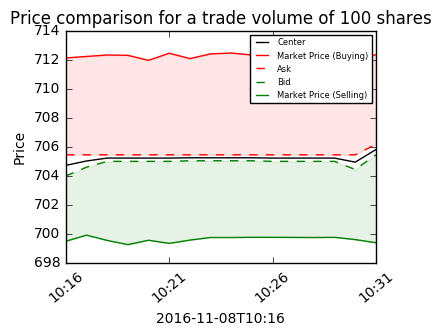

   1/1: acc_cost: 1.02090, steps: 4 (t=9)


,ACTION,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded,LIMIT_MAX
2016-11-08T10:16,0.6,705.45,704.00,704.724751,711.180,1.45,2,100.000000,708.28883,-21593.527862,0.154185,0,False,711.10,705.45,30.486896,715.0
2016-11-08T10:18,0.6,711.39,705.00,708.190195,713.556,6.39,2,69.513104,712.60970,-21952.114535,0.344670,0,False,713.40,711.39,30.805242,715.0
2016-11-08T10:20,0.6,707.33,705.00,706.164359,711.932,2.33,2,38.707862,708.59485,-2952.724906,0.022884,0,False,711.39,707.33,4.167014,715.0
2016-11-08T10:22,0.6,713.57,705.04,709.296452,714.428,8.53,2,34.540847,714.08830,-2462.638406,0.045822,0,False,714.35,713.57,3.448647,715.0
2016-11-08T10:24,0.6,715.00,705.04,710.008357,715.000,9.96,2,31.092200,715.00000,-22230.923307,0.453340,0,False,715.00,715.00,31.092200,715.0


(16, 8, 2)


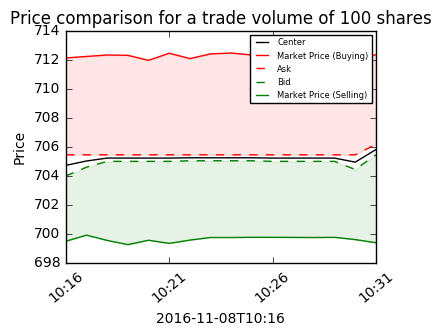

   1/1: acc_cost: 1.01861, steps: 4 (t=9)


,ACTION,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded,LIMIT_MAX
2016-11-08T10:16,0.7,705.45,704.00,704.724751,712.135,1.45,2,100.000000,708.68164,-24505.296604,0.194153,0,False,712.13,705.45,34.578710,715.0
2016-11-08T10:18,0.7,712.14,705.00,708.564004,714.142,7.14,2,65.421290,712.81659,-21069.954838,0.339401,0,False,714.00,712.14,29.558733,715.0
2016-11-08T10:20,0.7,707.33,705.00,706.164359,712.699,2.33,2,35.862558,708.83128,-2953.710077,0.024282,0,False,712.14,707.33,4.167014,715.0
2016-11-08T10:22,0.7,714.31,705.04,709.664909,714.793,9.27,2,31.695543,714.55281,-1534.232881,0.029944,0,False,714.70,714.31,2.147123,715.0
2016-11-08T10:24,0.7,715.00,705.04,710.008357,715.000,9.96,2,29.548420,715.00000,-21127.120429,0.430831,0,False,715.00,715.00,29.548420,715.0


(16, 8, 2)


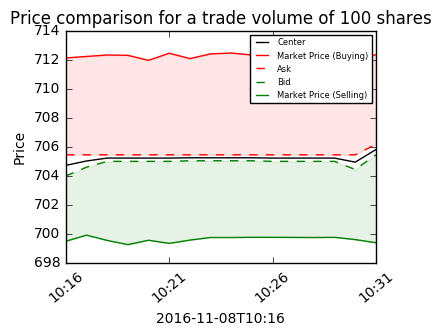

   1/1: acc_cost: 1.01997, steps: 7 (t=16)


,ACTION,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded,LIMIT_MAX
2016-11-08T10:16,0.1,705.45,704.00,704.724751,706.405,1.45,2,100.000000,705.56809,-3080.458015,0.005225,0,False,706.19,705.45,4.365926,715.0
2016-11-08T10:18,0.2,707.52,705.00,706.259251,709.016,2.52,2,95.634074,707.78782,-8919.102205,0.054772,0,False,709.00,707.33,12.601378,715.0
2016-11-08T10:20,0.2,707.16,705.00,706.079449,708.728,2.16,2,83.032696,707.16000,-3124.092926,0.015266,0,False,707.16,707.16,4.417802,715.0
2016-11-08T10:22,0.3,709.25,705.04,707.142911,710.975,4.21,2,78.614893,710.06871,-5926.755421,0.063294,0,False,710.86,709.25,8.346735,715.0
2016-11-08T10:24,0.4,711.73,705.04,708.379735,713.038,6.69,2,70.268158,712.50098,-20278.247515,0.314047,0,False,713.00,711.39,28.460659,715.0
2016-11-08T10:26,0.5,711.00,705.00,707.995763,713.000,6.00,2,41.807499,711.10125,-1936.462985,0.024640,0,False,711.39,711.00,2.723189,715.0
2016-11-08T10:28,0.6,713.96,705.00,709.470570,714.584,8.96,2,39.084311,714.25862,-1522.249835,0.028832,0,False,714.35,713.96,2.131231,715.0
2016-11-08T10:30,0.8,708.35,704.44,706.393196,713.670,3.91,2,36.953080,714.52513,-26403.904197,0.513895,0,True,715.00,708.35,36.953080,715.0


In [23]:
def run(V, T, P, epochs=1, overwrite_actions=None):
    for i_episode in range(epochs):
        ots = OrderbookTradingSimulator(orderbooks=episode_windows[1], volume=V, tradingperiods=T, decisionfrequency=P)
        plot_episode(episode_windows[1], volume=V)
        time_left = P*T
        volume = V

        state = np.array([time_left, volume])  # , volume])
        # state = discretize_state(state)

        acc_cost = 0
        for step in range(T):
            qval = model.predict(state.reshape(1, STATE_DIM))
            
            action = actions[np.argmin(qval)]
            
            if overwrite_actions and step < len(overwrite_actions):
                action = overwrite_actions[step]

            # info = ots.trade(orderbooks, limit=lim, verbose=False)
            info = ots.trade(agression_factor=action, verbose=False, extrainfo={'ACTION':action})

            time_left -= 1
            volume = ots.volume
            new_state = np.array([time_left, volume])  # , volume])
            cost = ots.history.cost.values[-1]

            acc_cost += cost

            state = new_state
            if volume == 0:
                break

        info = "{:4d}/{}: acc_cost: {:0.5f}, steps: {} (t={})"\
                .format(i_episode+1, epochs, acc_cost, step, ots.t)
        print(info)
    return ots.history
hist = run(V=V, T=T, P=P)  #, overwrite_actions=[0,0,0,0,0,0,0,0,0])
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.7]*10)
display(hist)
hist = run(V=V, T=T, P=P, overwrite_actions=[0.1, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8])
display(hist)

In [ ]:
plot_episode(episode_windows[3], volume=50, figsize=(5,3))
episode_windows[3][90].plot(range_factor=1.015, figsize=(5,3))

In [ ]:
def show_plots(x):
    # episode_windows[3][x].plot(range_factor=1.015, figsize=(5,3))
    return x

from ipywidgets import interact
interact(show_plots, x=5)

In [ ]:
print(len(obs))
for vol in [1, 50, 100]:
    market_order_price = []
    ask_price = []
    for i, ob in enumerate(obs):
        market_order_price.append(ob.get_current_price(volume=vol))
        ask_price.append(vol*ob.get_ask())

    plt.plot(market_order_price, color='blue', marker='o', label='market order price')
    plt.plot(ask_price, color='red', marker='*', label='ask price')
                         
                         
    
    plt.title("Market order price for {} shares".format(vol))
    plt.ylabel("price")
    plt.xlabel("time")
    plt.legend(loc='best')
    plt.xlim((-1,21))
    plt.show()